# News Classification

Dataset     :   BBC News (https://www.kaggle.com/datasets/balatmak/newsgroup20bbcnews)</br>
Deskripsi   :   Membuat model klasifikasi berita BBC</br>
Problem     :   Multiclass Classification

## Import Modules and Load Data

In [13]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from nltk import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load data

In [14]:
df = pd.read_csv('bbc-text.csv')
df.head(2)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...


In [15]:
# Make sure the description is string
df['text'] = df['text'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [16]:
# Create function to clean description with regular expression

STOPWORDS = set(stopwords.words('english')) # Set stopword
    
def clean_desc(description):
    #remove urls
    text1 = re.sub('http[s]?\://\S+','', description.lower())
    
    #remove numbers
    text2 = re.sub(r'[0-9]', '', text1)
    
    # only take letters
    text3 = re.sub('\W+',' ', text2)
    
    # remove extra spaces
    text4 = re.sub('\s+',' ', text3)
    
    # remove stopwords
    cleanstr = ' '.join(word for word in text4.split() if word not in STOPWORDS)
    
    return cleanstr

In [17]:
df['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

There are 5 categories/classes existing in the dataset.

In [18]:
# Apply clean_desc function

df['text'] = df['text'].apply(clean_desc)

In [19]:
# Check Max length of text
words = []

for i in df['text']:
    words.append(i)

maxwords = max([len(w) for w in words])

print ('Maximum sequence length in the list of sentences:', maxwords)

Maximum sequence length in the list of sentences: 16135


Text(0.5, 0, 'Category')

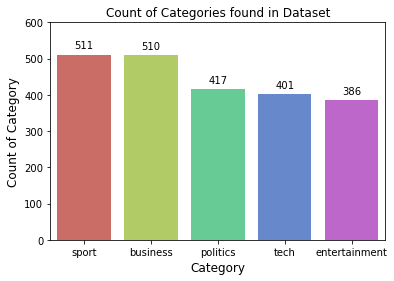

In [20]:
# Create simple barchart
dfbarchart = df.groupby(['category']).count().reset_index()
dfbarchart.columns = ['Category', 'Count of Category']
dfbarchart = dfbarchart.sort_values(by='Count of Category', ascending=False)

# Set simple barchart with seaborn
ax = sns.barplot(x='Category', y='Count of Category', data=dfbarchart, palette="hls")
ax.set_title('Count of Categories found in Dataset')

for p in ax.patches:
    ax.annotate(int(p.get_height()), 
                   (p.get_x() + p.get_width() / 2, p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
ax.set(ylim=(0, 600))
ax.set_ylabel('Count of Category', fontsize = 12)
ax.set_xlabel('Category', fontsize = 12)



## One Hot Encoding for Category

In [21]:

df = pd.get_dummies(df, columns=['category'], prefix='', prefix_sep='')
df.head(2)

,text,business,entertainment,politics,sport,tech
0,tv future hands viewers home theatre systems p...,0,0,0,0,1
1,worldcom boss left books alone former worldcom...,1,0,0,0,0


## Convert Data to Numpy Array

In [22]:
# Separate description and label into different variables 

description = df['text'].values
label = df[['business', 'entertainment', 'politics', 'sport', 'tech']].values

print(description)
print(label)

['tv future hands viewers home theatre systems plasma high definition tvs digital video recorders moving living room way people watch tv radically different five years time according expert panel gathered annual consumer electronics show las vegas discuss new technologies impact one favourite pastimes us leading trend programmes content delivered viewers via home networks cable satellite telecoms companies broadband service providers front rooms portable devices one talked technologies ces digital personal video recorders dvr pvr set top boxes like us tivo uk sky system allow people record store play pause forward wind tv programmes want essentially technology allows much personalised tv also built high definition tv sets big business japan us slower take europe lack high definition programming people forward wind adverts also forget abiding network channel schedules putting together la carte entertainment us networks cable satellite companies worried means terms advertising revenues w

## Set Tokenizer

In [23]:
# Set tokenizer
tokenizer = Tokenizer(num_words=50000, oov_token='x', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

# Tokenization on description text
tokenizer.fit_on_texts(description)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 27768 unique tokens.


## Change Text to Sequences

In [25]:
sequences = tokenizer.texts_to_sequences(description)

## Padding

In [26]:
padded_seq = pad_sequences(sequences, maxlen=3000)

## Separate Training and Testing Data

In [27]:
# Using 20% validation set
description_train, description_test, label_train, label_test = train_test_split(padded_seq, label, test_size=0.2, random_state=42)

print(description_train.shape,label_train.shape)
print(description_test.shape,label_test.shape)

(1780, 3000) (1780, 5)
(445, 3000) (445, 5)


## Setup Model

Setup model sequential with Embedding, LSTM, and Dropout.

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(50000,100,input_length=3000),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [29]:
# Compile model with specified loss and optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3000, 100)         5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 3000, 100)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________


## Callback

In [30]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.90 and logs.get('val_accuracy')>0.90):
            print("\Accuracy has reached 90%, training will be stoped!")
            self.model.stop_training=True
callbacks = myCallback()


## Fit Model

In [32]:
num_epochs = 30
history = model.fit(description_train, label_train, epochs=num_epochs, 
                    validation_data=(description_test, label_test), verbose=2, callbacks=[callbacks])

Epoch 1/30
56/56 - 1688s - loss: 1.5685 - accuracy: 0.3517 - val_loss: 1.4459 - val_accuracy: 0.4494 - 1688s/epoch - 30s/step
Epoch 2/30
56/56 - 2713s - loss: 0.8889 - accuracy: 0.7579 - val_loss: 0.8495 - val_accuracy: 0.7528 - 2713s/epoch - 48s/step
Epoch 3/30
56/56 - 3574s - loss: 0.3995 - accuracy: 0.9107 - val_loss: 0.3583 - val_accuracy: 0.8876 - 3574s/epoch - 64s/step
Epoch 4/30
\Accuracy has reached 90%, training will be stoped!
56/56 - 3784s - loss: 0.0801 - accuracy: 0.9871 - val_loss: 0.3372 - val_accuracy: 0.9056 - 3784s/epoch - 68s/step


## Display Plot Loss and Accuracy for Train and Validation

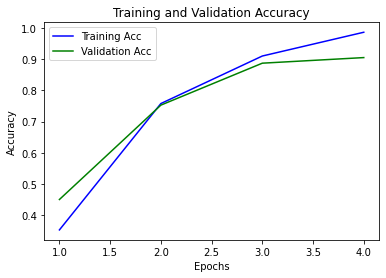

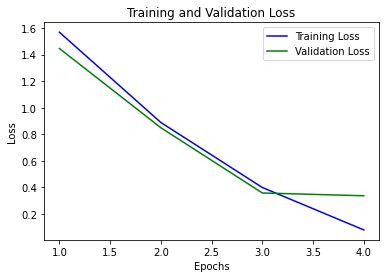

In [45]:
# Accuracy Plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training Acc')
plt.plot(epochs, val_acc, 'g', label='Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and Validation Accuracy')
plt.legend()
fig = plt.figure()
fig.savefig('acc.png')

# Training Plot
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.legend()
plt.show()

## Test Predict News Articles

In [40]:
import numpy as np
new_complaint = ['On the shore of the Red Sea, the forward-thinking town of El Gouna was founded with a mission: to do its part to protect the environment.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=3000)
pred = model.predict(padded)
labels = ['Business','Entertainment','Politics','Sports','Tech']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 253ms/step
[[1.9721575e-03 9.7876066e-01 2.0878385e-03 4.7897978e-04 1.6700421e-02]] Entertainment
